In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionResNetV2, EfficientNetB7
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [3]:
def plot_image(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    
    plt.show()
    
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()
    
    plt.show()

In [4]:
def display_examples(validation_generator, y_pred_classes):
    list_idx = sample(range(len(validation_generator.filenames)), 9)  

    fig = plt.figure(figsize=(10, 10))  
    fig.subplots_adjust(hspace=0.8, wspace=0.4)  

    class_indices_reversed = {v: k for k, v in validation_generator.class_indices.items()}  

    for i, idx in enumerate(list_idx):
        try:
            img_path = validation_generator.filepaths[idx]
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array / 255.0  

            true_label = validation_generator.classes[idx]
            true_label_name = class_indices_reversed[true_label]

            pred_label = y_pred_classes[idx]
            pred_label_name = class_indices_reversed[pred_label]

            plt.subplot(3, 3, i + 1)
            plt.imshow(img_array)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)

            label_color = 'green' if true_label_name == pred_label_name else 'red'

            plt.xlabel(f"True: {true_label_name}\nPred: {pred_label_name}", fontsize=8, color=label_color)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    plt.show()


In [5]:
dataset_path = "/kaggle/input/face-shape-3classes/face-shape-new"

print('List dir:')
for file in os.listdir(dataset_path):
  print(file)

List dir:
test_set
training_set


In [6]:
# setup train & testing dir
train_dir = os.path.join(dataset_path, 'training_set')
test_dir = os.path.join(dataset_path, 'test_set')

In [7]:
img_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

In [8]:
train_generator = img_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
        )

validation_generator = img_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
        )

Found 4819 images belonging to 3 classes.
Found 1254 images belonging to 3 classes.


**VGG16**

In [9]:
vgg16_model = VGG16(
    input_shape=(224, 224, 3),           
    include_top=False,                   
    weights=None,
    pooling='max'
)

vgg16_model.load_weights('/kaggle/input/vgg16/keras/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop (1).h5')

In [10]:
# freeze layer
for layer in vgg16_model.layers :
    layer.trainable = False

In [11]:
tl1_model = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3,activation='softmax'),
])

In [12]:
tl1_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
tl1_model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [14]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True) 


In [16]:
history1 = tl1_model.fit(
    train_generator,
    validation_data=validation_generator,  
    epochs=50,
    verbose=2,
    callbacks=[early_stopping])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732437247.888686     112 service.cc:145] XLA service 0x7d4738005690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732437247.888744     112 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732437247.888748     112 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732437268.082457     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


151/151 - 86s - 568ms/step - accuracy: 0.3988 - loss: 1.1121 - val_accuracy: 0.4864 - val_loss: 1.0322
Epoch 2/50
151/151 - 32s - 215ms/step - accuracy: 0.4939 - loss: 1.0064 - val_accuracy: 0.5311 - val_loss: 0.9849
Epoch 3/50
151/151 - 33s - 219ms/step - accuracy: 0.5439 - loss: 0.9528 - val_accuracy: 0.5766 - val_loss: 0.9391
Epoch 4/50
151/151 - 32s - 215ms/step - accuracy: 0.5931 - loss: 0.9003 - val_accuracy: 0.5869 - val_loss: 0.9051
Epoch 5/50
151/151 - 33s - 216ms/step - accuracy: 0.6157 - loss: 0.8507 - val_accuracy: 0.6196 - val_loss: 0.8643
Epoch 6/50
151/151 - 33s - 218ms/step - accuracy: 0.6632 - loss: 0.7949 - val_accuracy: 0.6276 - val_loss: 0.8368
Epoch 7/50
151/151 - 33s - 219ms/step - accuracy: 0.6779 - loss: 0.7605 - val_accuracy: 0.6356 - val_loss: 0.8167
Epoch 8/50
151/151 - 33s - 218ms/step - accuracy: 0.7016 - loss: 0.7262 - val_accuracy: 0.6411 - val_loss: 0.8053
Epoch 9/50
151/151 - 33s - 218ms/step - accuracy: 0.7103 - loss: 0.7025 - val_accuracy: 0.6762 - va

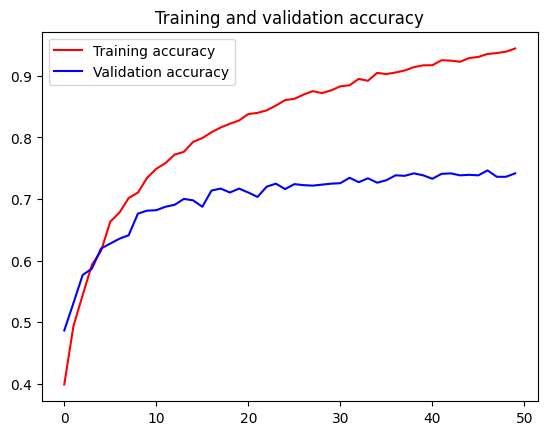

<Figure size 640x480 with 0 Axes>

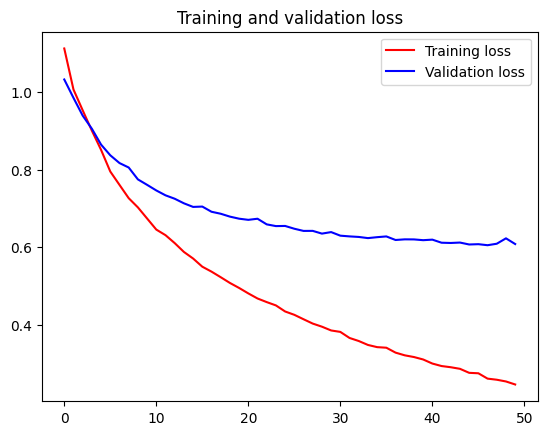

<Figure size 640x480 with 0 Axes>

In [17]:
plot_image(history1)

In [37]:
tl1_model.save('tl_vgg16_2.h5')

In [ ]:
# loss, accuracy = model.evaluate(validation_generator)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

In [34]:
y_pred = tl2.predict(validation_generator)
y_pred_classes = y_pred.argmax(axis=1)

y_true = validation_generator.classes

40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step


In [35]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.34      0.54      0.42       434
           1       0.30      0.26      0.28       414
           2       0.29      0.16      0.21       406

    accuracy                           0.32      1254
   macro avg       0.31      0.32      0.30      1254
weighted avg       0.31      0.32      0.30      1254



In [ ]:
# display_examples(validation_generator, y_pred_classes)

**InceptionResNetV2**

In [18]:
ir_model = InceptionResNetV2(
    input_shape=(224, 224, 3),           
    include_top=False,                   
    weights='imagenet'             
)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
for layer in ir_model.layers:
    layer.trainable = False

In [21]:
tl2 = tf.keras.models.Sequential([
    ir_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(3,activation='softmax'),
])

tl2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ ?                      │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 54,336,736 (207.28 MB)

In [22]:
tl2.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [23]:
history2 = tl2.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/30
151/151 - 90s - 598ms/step - accuracy: 0.4980 - loss: 1.0482 - val_accuracy: 0.5367 - val_loss: 0.9351
Epoch 2/30
151/151 - 33s - 220ms/step - accuracy: 0.6678 - loss: 0.7520 - val_accuracy: 0.6236 - val_loss: 0.8501
Epoch 3/30
151/151 - 33s - 220ms/step - accuracy: 0.7533 - loss: 0.6123 - val_accuracy: 0.6228 - val_loss: 0.8263
Epoch 4/30
151/151 - 33s - 217ms/step - accuracy: 0.8134 - loss: 0.5068 - val_accuracy: 0.6252 - val_loss: 0.8375
Epoch 5/30
151/151 - 33s - 219ms/step - accuracy: 0.8568 - loss: 0.4274 - val_accuracy: 0.6308 - val_loss: 0.8438


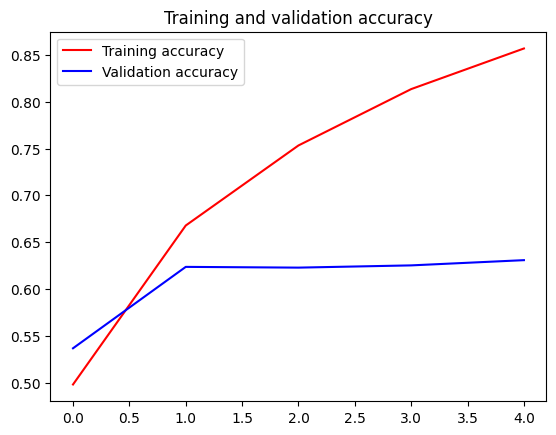

<Figure size 640x480 with 0 Axes>

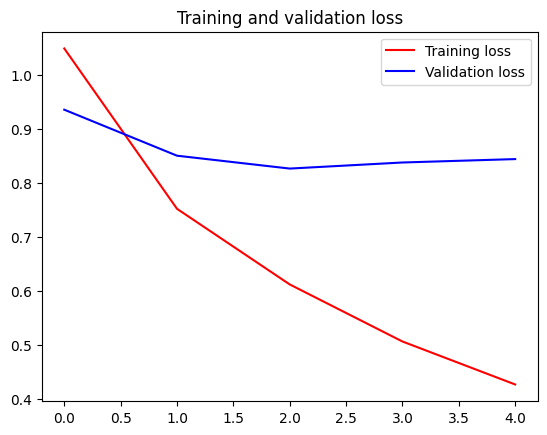

<Figure size 640x480 with 0 Axes>

In [24]:
plot_image(history2)

In [36]:
tl2.save('tl_IR.h5')